In [1]:
# Just a bit of code to run through the HDF5 file and load into a
# geopandas geodataframe.
#
# Written 5/28/21 by W. Sauthoff (sauthoff@mines.edu)
# Modified 6/8/21 by M. Siegfried (siegfried@mines.edu)

# import standard library packages
import os.path

# import external packages
import geopandas as gpd
import h5py
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from pyproj import CRS, Transformer
import numpy as np
from shapely.geometry import Polygon, MultiPolygon

In [2]:
# import subglacial lake outlines (Siegfried & Fricker, 2018)
h5f = h5py.File('SiegfriedFricker2018-outlines.h5', 'r')
outline_geometries = [] # store polygons
citations = [] # store citation information

# we're going to calculate geodesic lake area because that is often screwed up
# and occasionally incorrect in the literature
areas = []

# we're going to need to do some coordinate transforms for the geodesic area
# define CRS for Antarcica and make a converter from xy to ll
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
CRS_XY = h5f.attrs.get('proj_crs') # get projection from hdf5 file
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid

# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)

    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
        lon, lat = XY_TO_LL.transform(outlines_xy[:,0], outlines_xy[:,1])
        this_area = abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
    else:
        this_area = 0
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]

        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
        this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6 # add its area
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]

            pgons.append(Polygon(this_outline))
            lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
            this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
        geometry = MultiPolygon(pgons)

    # append all the results in the right place
    outline_geometries.append(geometry)
    citations.append(h5f[lake].attrs.get('citation')[0].decode('UTF-8'))
    areas.append(this_area)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries, areas, citations),
                  columns=['name', 'geometry', 'area (km^2)', 'cite'])
# convert to geopands geodataframe
gdf = gpd.GeoDataFrame(df, crs=CRS_XY, geometry=outline_geometries)
# close HDF5 file
h5f.close()

In [4]:
gdf.to_file('file.shp', driver='ESRI Shapefile')

/var/folders/7k/9p6bgnfs75513xxbgkfm73tr0000gn/T/ipykernel_2124/2764429293.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('file.shp', driver='ESRI Shapefile')


In [17]:
# locate a single lake to ensure HDF5 was read properly
gdf.loc[gdf['name']=='MercerSubglacialLake']

,name,geometry,area (km^2),cite
93,MercerSubglacialLake,"POLYGON ((-299950.018 -500675.034, -299949.971...",143.202974,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."


In [52]:
len(gdf)
wh_lakes = np.zeros(len(gdf)).astype(bool)
for i in range(len(gdf)):
    if gdf.centroid[i].x < -200000 and \
        gdf.centroid[i].x > -400000 and \
        gdf.centroid[i].y < -450000 and \
        gdf.centroid[i].y > -700000 :
        print('hit')
        wh_lakes[i] = 1

hit
hit
hit
hit
hit
hit
hit
hit


In [49]:
gdf.centroid.y

0     -6.964783e+05
1     -7.071226e+05
2     -6.483884e+05
3     -5.871411e+05
4     -5.717129e+05
           ...     
126   -4.889175e+05
127   -5.018446e+05
128   -2.829098e+05
129   -6.695342e+05
130   -1.225393e+06
Length: 131, dtype: float64

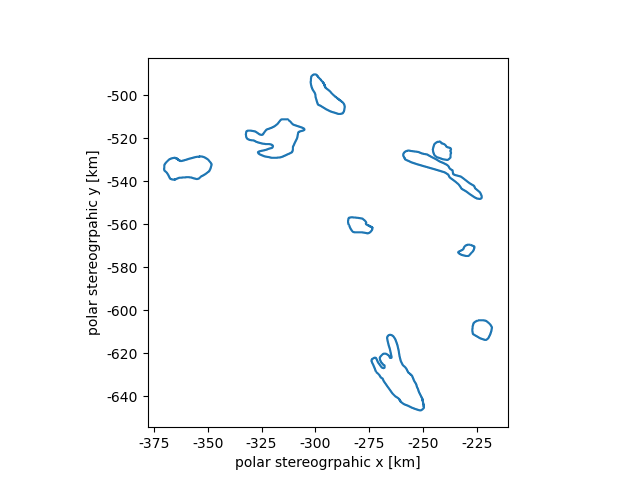

In [55]:
%matplotlib widget

# plot lakes outlines and zoom into lower Mercer/Whillans lakes (because we love those lakes)
fig, ax = plt.subplots()
gdf[wh_lakes].boundary.plot(ax=ax)
# change polar stereographic m to km for cleaner-looking axes labels
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
# set axes limits
#ax.set_xlim(-400000,-175000)
#ax.set_ylim(-700000,-450000)
# label axes
ax.set_xlabel('polar stereogrpahic x [km]')
ax.set_ylabel('polar stereogrpahic y [km]')
plt.show()

In [7]:
# export outlines to kml file to view in Quantarctica, Google Earth, etc.
# ensure KML driver is supported
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
# ensure file hasn't already been created
if os.path.exists('./SiegfriedFricker2018-outlines.kml') == False:
    gdf.to_file('SiegfriedFricker2018-outlines.kml', driver='KML')
else:
    print('file already exists')

AttributeError: 'NoneType' object has no attribute 'drvsupport'